# Intro

This Jupyter notebook can help you plan your yearly budget as a ZZP in 2023. 

Specifically, it can forecast (on a monthly basis) your:
- tax liabilities
- and disposable income

The calculations are based on your:
- profit
- pension contributions
- savings
- your eligibility to:
    - zelfstandigenaftrek
    - startersaftrek
    - and mkb-winstvrijstelling


It also allows you to set your saving goals and see how your monthly disposable income gets affected.

===

DISCLAIMER: Even though I strived to implement the calculations to the best of my abilities, I am not an accountant and I cannot guarantee everything here are correct. Use it at your own risk. If you spot a mistake, please contact me or submit a pull request.

===

NOTE: If you want more functionality added, feel free to submit a pull request, or drop me an [e-mail](mailto:eugene.blokhin@gmail.com?subject=Tax+calculations+notebook), and I will consider adding the requested functionality.

Repo: https://github.com/eugene-blokhin/financial-forecasting



Eugene Blokhin
- LinkedIn: https://www.linkedin.com/in/eblokhin/
- GitHub: https://github.com/eugene-blokhin/
- CV: https://eugene-blokhin.com/

# Configuration

In [398]:
import pandas as pd
import os
import json

data = {
    
    'mkb_winstvrijstelling': True,
    
    #See https://www.belastingdienst.nl/wps/wcm/connect/bldcontentnl/belastingdienst/zakelijk/winst/inkomstenbelasting/veranderingen-inkomstenbelasting-2023/ondernemersaftrek-2023/zelfstandigenaftrek-2023
    'zelfstandigenaftrek': True,
    'startersaftrek': True,
    
    'months': [
        { 'revenue': 10000, 'costs': 0, 'pension_contributions': 1000, 'savings': 1000 }, # Jan
        # { 'revenue': 10000, 'costs': 0, 'pension_contributions': 0, 'savings': 0 }, # Feb
        # { 'revenue': 10000, 'costs': 0, 'pension_contributions': 0, 'savings': 0 }, # Mar
        # { 'revenue': 10000, 'costs': 0, 'pension_contributions': 0, 'savings': 0 }, # Apr
        # { 'revenue': 10000, 'costs': 0, 'pension_contributions': 0, 'savings': 0 }, # May
        # ... you can either complete the list based on your expectations, or the average values will be used for the remaining months
    ],
    'goals': [
        { 'title': 'Traveling to India', 'dueDate': '2023-11-01', 'amount': 2500 }
    ]
}

# If you prefer using a json file, you can create one based on data.example.json
if os.path.exists('data.json'):
    with open('data.json', 'rt') as f:
        data = json.load(f)

# Calculations

## Preparing the data

In [399]:
months = data['months']

fields = ['revenue', 'costs', 'pension_contributions', 'savings']

# Fill in the missing fields
for month in months:
    for field in fields:
        
        if field not in month:
            month[field] = 0
            
# Extrapolate the data
avg_month = {}
for field in fields:
    avg_value = sum(map(lambda x: x[field], months)) / len(months)
    avg_month[field] = avg_value
    
for _ in range(12 - len(months)):
    months.append(avg_month)

## Calculation

In [400]:
from taxes2023 import *

apply_zelfstandigenaftrek = data['zelfstandigenaftrek']
apply_mkb_winstvrijstelling = data['mkb_winstvrijstelling']
apply_startersaftrek = data['startersaftrek']

df = pd.DataFrame.from_records(months)

df.index = pd.date_range("2023-01-01", periods=12, freq="M")

df['profit'] = \
    df['revenue'] \
    - df['costs']

df['cum_revenue'] = df['revenue'].cumsum()
df['cum_costs'] = df['costs'].cumsum()
df['cum_profit'] = df['profit'].cumsum()
df['cum_pension_contributions'] = df['pension_contributions'].cumsum()
df['cum_savings'] = df['savings'].cumsum()

# revenue deductions
if apply_mkb_winstvrijstelling:
    df['zelfstandigenaftrek'] = df['cum_profit'].map(lambda x: calculate_zelfstandigenaftrek(x, apply_startersaftrek))
    df['mkb_winstvrijstelling'] = (df['cum_profit'] - df['zelfstandigenaftrek']).map(calculate_mkb_winstvrijstelling)
    
    df['ondernemersaftrekken'] = \
        df['zelfstandigenaftrek'] \
        + df['mkb_winstvrijstelling']
else:
    df['ondernemersaftrekken'] = 0
    
# tax and discounts
df['box_1_income'] = \
    df['cum_profit'] \
    - df['ondernemersaftrekken'] \
    - df['cum_pension_contributions']

df['tax'] = df['box_1_income'].map(calculate_tax)
df['alg_heffingskorting'] = df['box_1_income'].map(calculate_algemene_heffingskorting)
df['arbeidskorting'] = df['cum_profit'].map(calculate_arbeidskorting)

df['tariefsaanpassing_box_1'] = df.apply(lambda r: calculate_tariefsaanpassing_box_1(r['cum_profit'], r['ondernemersaftrekken']), axis = 1)


df['income_tax_due'] = \
    df['tax'] \
    - df['alg_heffingskorting'] \
    - df['arbeidskorting'] \
    + df['tariefsaanpassing_box_1']

df['zvw_tax_due'] = (df['box_1_income'] + df['cum_pension_contributions']).map(calculate_zvw)

df['total_tax_due'] = \
    df['income_tax_due'] \
    + df['zvw_tax_due']

# income and investments
df['cum_net_income'] = \
    df['cum_profit'] \
    - df['total_tax_due'] \
    - df['cum_pension_contributions']

# savings & disposable_income
df['cum_savings'] = df['savings'].cumsum()

df['disposable_income'] = \
    df['cum_net_income'] \
    - df['cum_savings']

df['tax_return'] = df['total_tax_due'].map(lambda x: max(0, -x))
df['total_tax_due'] = df['total_tax_due'].map(lambda x: max(0, x))
df['effective_tax_rate'] = (df['total_tax_due'] - df['tax_return'])/ df['cum_profit']

# display(df)

total_gross_income = df.iloc[-1]["cum_profit"]
total_net_income = df.iloc[-1]["cum_net_income"]
total_disposable_income = df.iloc[-1]["disposable_income"]
total_savings = df.iloc[-1]["cum_savings"]
total_pension = df.iloc[-1]["cum_pension_contributions"]
effective_tax_rate = df.iloc[-1]["effective_tax_rate"]

print(f'Gross income: {total_gross_income:n} \n\t(avg. per month: {total_gross_income / 12:n})')
print(f'Effective tax rate: {effective_tax_rate:n}')
print('----')
print(f'Net income: {total_net_income:n} \n\t(avg. per month: {total_net_income / 12:n})')
print(f'Disposable income: {total_disposable_income:n} \n\t(avg. per month: {total_disposable_income / 12:n})')
print('----')
print(f'Savings: {total_savings:n}')
print(f'Pension contributions: {total_pension:n}')

df_refined = df.loc[:, ['total_tax_due', 'cum_pension_contributions', 'cum_savings', 'disposable_income', 'tax_return']]

Gross income: 120000 
	(avg. per month: 10000)
Effective tax rate: 0.328664
----
Net income: 68560.3 
	(avg. per month: 5713.36)
Disposable income: 56560.3 
	(avg. per month: 4713.36)
----
Savings: 12000
Pension contributions: 12000


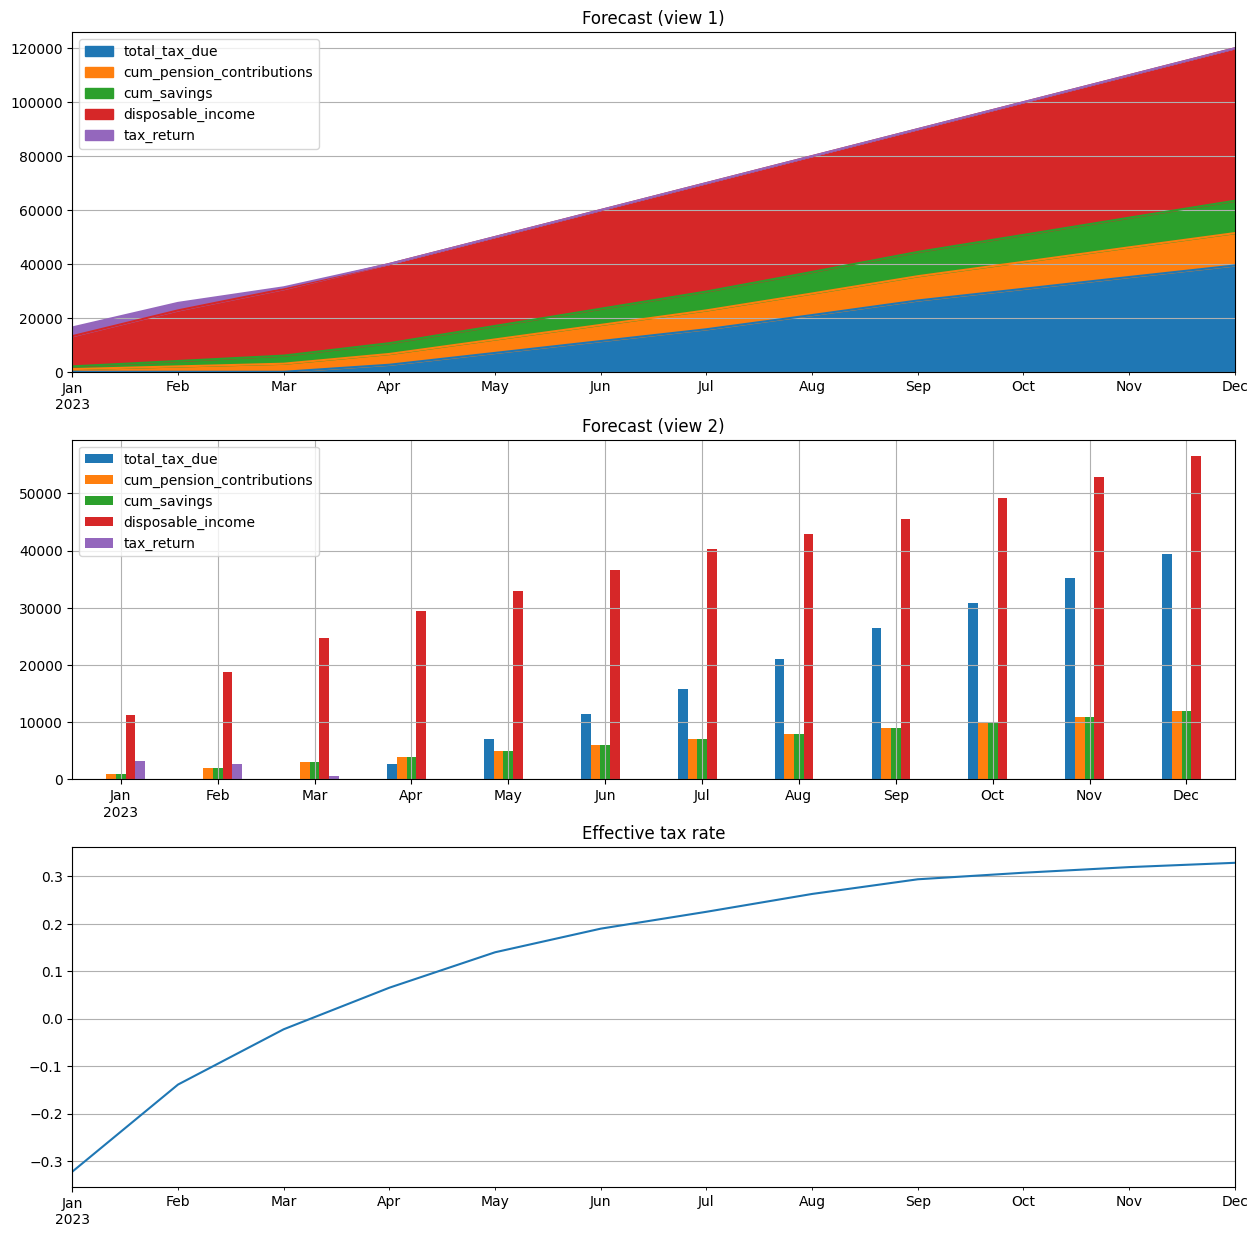

In [401]:
import matplotlib.pyplot as plt

def line_format(label):
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

df_refined.plot.area(grid=True, title='Forecast (view 1)', ax=ax1)

df_refined.plot.bar(grid=True, title='Forecast (view 2)', ax=ax2)
ax2.set_xticklabels(map(line_format, df.index), rotation=0)
df.loc[:,'effective_tax_rate'].plot(grid=True, title='Effective tax rate', ax=ax3)

plt.show()

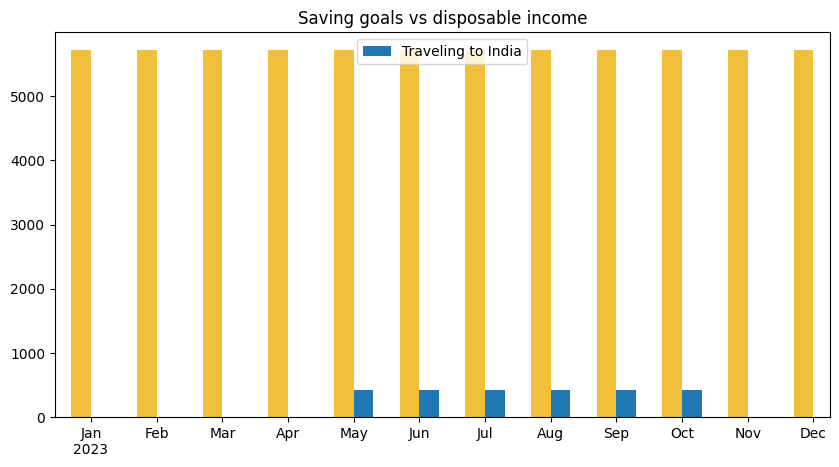

In [404]:
from datetime import datetime, date
import calendar
from dateutil.relativedelta import relativedelta

goals = data['goals'] if 'goals' in data else []

if len(goals) > 0:
    def get_last_day_of_month(date: datetime):
        last_day_of_month = calendar.monthrange(date.year, date.month)[1]
        return datetime(date.year, date.month, last_day_of_month)

    today = datetime.now().date()
    goal_dfs = []
    for goal in goals:
        amount = goal['amount']
        due_date = datetime.strptime(goal['dueDate'], '%Y-%m-%d')
        title = goal['title']

        last_date_of_month = get_last_day_of_month(due_date)
        if last_date_of_month != due_date:
            due_date = last_date_of_month - relativedelta(months=1)

        time_left_in_year = relativedelta(due_date, today)
        months_left_in_year = time_left_in_year.years * 12 + time_left_in_year.months + 1

        due_dates = [get_last_day_of_month(due_date - relativedelta(months=m)) for m in range(months_left_in_year)]
        amounts = [amount / months_left_in_year for _ in range(months_left_in_year)]

        goal_df = pd.DataFrame({'date': due_dates, title: amounts})
        goal_df.set_index(['date'], inplace=True)
        goal_dfs.append(goal_df)

    payments_df = pd.concat([
        (df['profit'] * (1-effective_tax_rate) - df['savings']).to_frame('disposable_income'),
        *goal_dfs], 
        axis=1
    )

    ax = payments_df.iloc[:,1:].plot.bar(stacked=True, position = 0, figsize=(10,5), width=0.3)
    payments_df.iloc[:,0].plot.bar(stacked=True, position = 1, ax= ax, color='#f0c03c', width=0.3, title='Saving goals vs disposable income')
    _ = ax.set_xticklabels(map(line_format, payments_df.index), rotation=0)
    
else:
    print('No goals set')